In [1]:
#Do not run
from IPython.display import Image
Image(url= "images/crispdm.png", width=400)

In [1]:
# data
import pandas as pd
import numpy as np
from datetime import datetime
from math import ceil

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# processing
from sklearn.impute import KNNImputer
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.base import clone

# clustering models
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# metrics
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score, silhouette_samples

# multidimensional visualization methods
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
sns.set()
%matplotlib inline

# Business Understanding: 
https://github.com/joaopfonseca/business-cases-21-22/tree/main/BC1_customer_segmentation

# Data Understanding: 

### Data Exploration
- view the original dataset
- outliers
- null values

In [2]:
# read the dataset
df = pd.read_excel('WonderfulWinesoftheWorld.xlsx')
df.Custid.fillna(11001.0, inplace=True)
df.set_index('Custid', inplace = True)

In [3]:
# create a copy of the original df for preprocessing
df_backup = df.copy()

In [4]:
# first rows - view the structure
df.tail()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
Custid,,,,,,,,,,,,,,,,,
4070.0,596.000,66.0000,15.0000,84714.000,18.0000,45.0000,720.0000,391.0000,5.0000,30.0000,12.0000,36.0000,10.0000,12.0000,13.0000,18.0000,2.0000
7909.0,619.000,18.0000,12.0000,40466.000,3.0000,65.0000,47.0000,5.0000,23.0000,6.0000,24.0000,10.0000,38.0000,22.0000,41.0000,58.0000,5.0000
4158.0,1107.000,33.0000,16.0000,53661.000,1.0000,368.0000,15.0000,2.0000,35.0000,18.0000,13.0000,45.0000,11.0000,13.0000,13.0000,60.0000,6.0000
4914.0,979.000,55.0000,16.0000,94926.000,25.0000,28.0000,1148.0000,293.0000,7.0000,63.0000,10.0000,13.0000,11.0000,3.0000,4.0000,34.0000,5.0000
11001.0,898.102,47.9273,16.7391,69904.358,14.6281,62.4068,622.5552,209.0712,32.3972,50.3827,7.0545,28.5213,7.0698,6.9474,16.5466,42.3762,5.2166


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10001 entries, 5325.0 to 11001.0
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Dayswus      10001 non-null  float64
 1   Age          10001 non-null  float64
 2   Edu          10001 non-null  float64
 3   Income       10001 non-null  float64
 4   Freq         10001 non-null  float64
 5   Recency      10001 non-null  float64
 6   Monetary     10001 non-null  float64
 7   LTV          10001 non-null  float64
 8   Perdeal      10001 non-null  float64
 9   Dryred       10001 non-null  float64
 10  Sweetred     10001 non-null  float64
 11  Drywh        10001 non-null  float64
 12  Sweetwh      10001 non-null  float64
 13  Dessert      10001 non-null  float64
 14  Exotic       10001 non-null  float64
 15  WebPurchase  10001 non-null  float64
 16  WebVisit     10001 non-null  float64
dtypes: float64(17)
memory usage: 1.4 MB


In [7]:
# the dataset has null values - how to correct them?
df.isna().sum()

Dayswus        0
Age            0
Edu            0
Income         0
Freq           0
Recency        0
Monetary       0
LTV            0
Perdeal        0
Dryred         0
Sweetred       0
Drywh          0
Sweetwh        0
Dessert        0
Exotic         0
WebPurchase    0
WebVisit       0
dtype: int64

In [8]:
#Checking for duplicates: 
duplicate=df.duplicated()
print(duplicate.sum())
df[duplicate]

0


,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic,WebPurchase,WebVisit
Custid,,,,,,,,,,,,,,,,,


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Dayswus,10001.0,898.1020,202.482664,550.0,724.0,894.0,1074.0,1250.0
Age,10001.0,47.9273,17.301856,18.0,33.0,48.0,63.0,78.0
Edu,10001.0,16.7391,1.876281,12.0,15.0,17.0,18.0,20.0
Income,10001.0,69904.3580,27610.852665,10000.0,47646.0,70009.0,92147.0,140628.0
Freq,10001.0,14.6281,11.968475,1.0,4.0,12.0,24.0,56.0
Recency,10001.0,62.4068,69.870762,0.0,26.0,52.0,78.0,549.0
Monetary,10001.0,622.5552,647.102966,6.0,63.0,383.0,1077.0,3052.0
LTV,10001.0,209.0712,291.971441,-178.0,-2.0,57.0,364.0,1791.0
Perdeal,10001.0,32.3972,27.895699,0.0,6.0,25.0,56.0,97.0
Dryred,10001.0,50.3827,23.452643,1.0,32.0,51.0,69.0,99.0


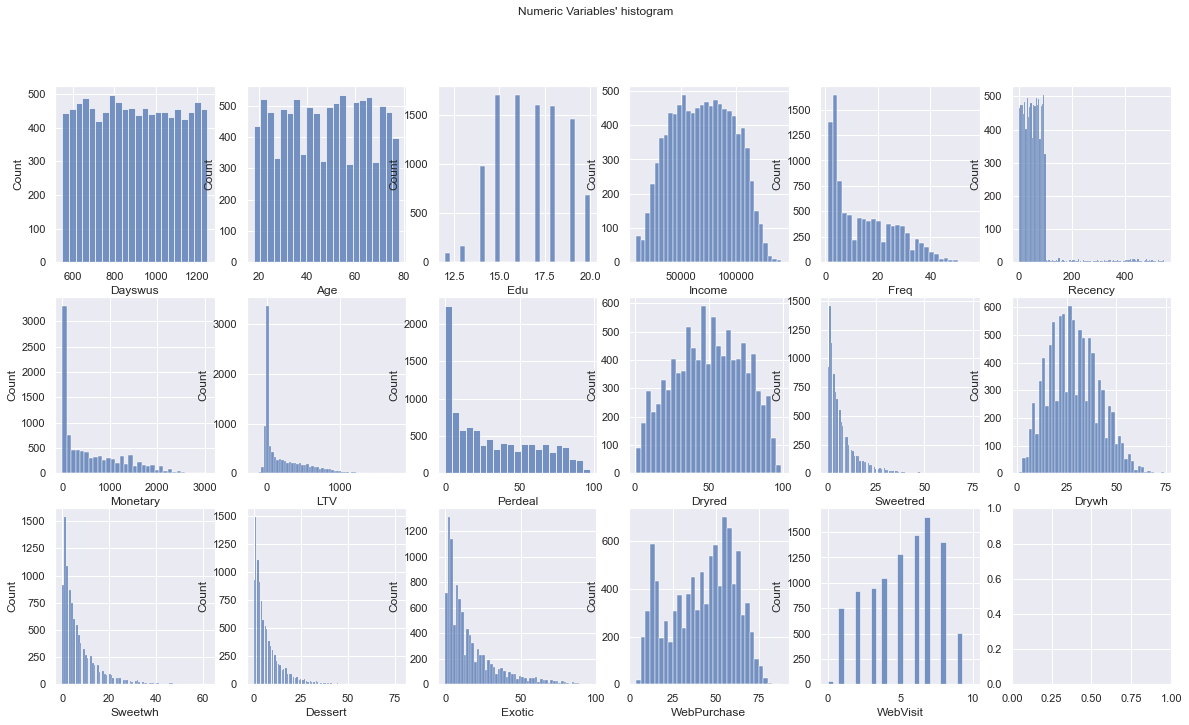

In [10]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.histplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' histogram"

plt.suptitle(title)

plt.show()


### Outliers

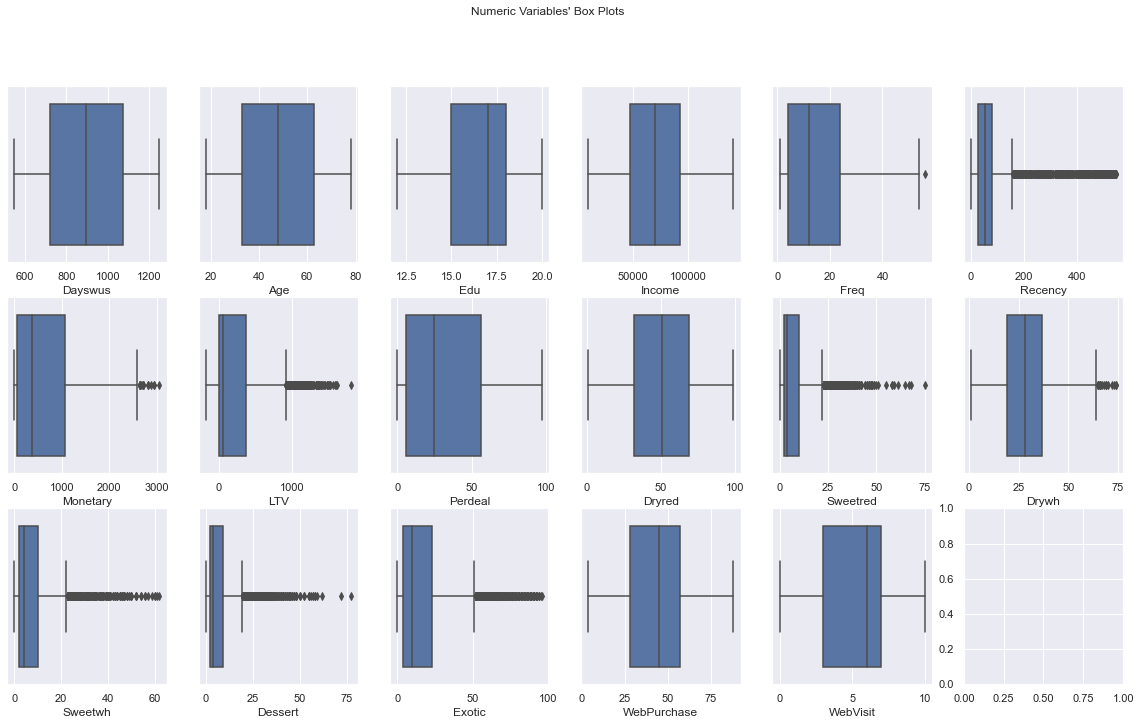

In [11]:
# plot outliers
%matplotlib inline
num_vars=df.select_dtypes(include=np.number).set_index(df.index)

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(3, ceil(num_vars.shape[1] / 3), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(x=num_vars[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables' Box Plots"

plt.suptitle(title)

plt.show()

# Data Preparation:

## Dealing with Outliers: 

## DBscan

In [12]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

In [13]:
df_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Dayswus,10001.0,0.011720,0.578522,-0.982857,-0.485714,0.0,0.514286,1.017143
Age,10001.0,-0.002423,0.576729,-1.000000,-0.500000,0.0,0.500000,1.000000
Edu,10001.0,-0.086967,0.625427,-1.666667,-0.666667,0.0,0.333333,1.000000
Income,10001.0,-0.002351,0.620455,-1.348487,-0.502528,0.0,0.497472,1.586908
Freq,10001.0,0.131405,0.598424,-0.550000,-0.400000,0.0,0.600000,2.200000
Recency,10001.0,0.200131,1.343668,-1.000000,-0.500000,0.0,0.500000,9.557692
Monetary,10001.0,0.236248,0.638169,-0.371795,-0.315582,0.0,0.684418,2.632150
LTV,10001.0,0.415495,0.797736,-0.642077,-0.161202,0.0,0.838798,4.737705
Perdeal,10001.0,0.147944,0.557914,-0.500000,-0.380000,0.0,0.620000,1.440000
Dryred,10001.0,-0.016684,0.633855,-1.351351,-0.513514,0.0,0.486486,1.297297


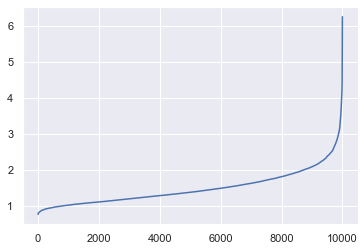

In [14]:
# K-distance graph to find out the right eps value
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_norm)
distances, _ = neigh.kneighbors(df_norm)
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

In [15]:
dbscan = DBSCAN(eps=2.7, min_samples=20, n_jobs=6)
dbscan_labels = dbscan.fit_predict(df_norm)
Counter(dbscan_labels)

Counter({0: 9941, -1: 60})

In [16]:
# Save the newly detected outliers (they will be classified later based on the final clusters)
df_out = df[dbscan_labels==-1].copy()

# New df without outliers
df = df[dbscan_labels!=-1]\
    .copy()

# New df without outliers
df_norm = df_norm[dbscan_labels!=-1]\
    .copy()

In [17]:
df=df.reset_index(drop=True)

In [18]:
df_norm=df_norm.reset_index(drop=True)

## Feature selection: Correlation matrix

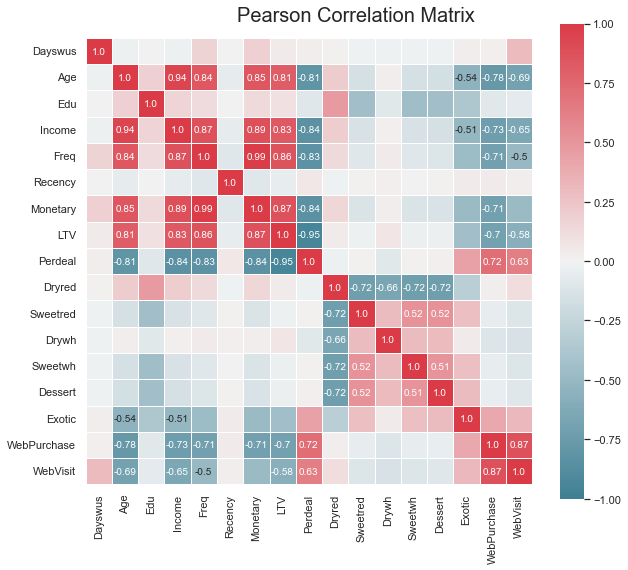

In [19]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df.corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

In [20]:
# age or income 
#df.drop('Age',inplace=True,axis=1)

# do not use monetary and recency 
#list of possible variables:

#LTV, WebVisit, frequency

#

In [21]:
## Pairwise Relationship of Numerical Variables
#sns.set()
#
## Setting pairplot
#sns.pairplot(df, diag_kind="hist", corner=True)
#
## Layout
#plt.subplots_adjust(top=0.95)
#plt.suptitle("Pairwise Relationship of Numerical Variables", fontsize=20)
#
#plt.show()

In [22]:
#there were no duplicated observations. 
df.duplicated().unique()

array([False])

### Feature Engineering:

In [23]:
df.columns

Index(['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal', 'Dryred', 'Sweetred', 'Drywh', 'Sweetwh', 'Dessert',
       'Exotic', 'WebPurchase', 'WebVisit'],
      dtype='object')

In [24]:
#years as customer
df["YearsAsCustomer"]=round(df.Dayswus/365,1)

#income
df["logIncome"]=df["Income"].map(lambda x : 1 if x<=1 else x)
df["logIncome"]=np.log(df["logIncome"])

#LTV
df["logLTV"]=df["LTV"].map(lambda x : 1 if x<=1 else x)
df["logLTV"]=np.log(df["logLTV"])

## PCA

In [25]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

In [26]:
df_pca = df_norm[['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal','WebPurchase', 'WebVisit', 'YearsAsCustomer', 'logIncome',
       'logLTV']].copy()

In [27]:
pca = PCA()
pca_feat = pca.fit_transform(df_pca)

# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).round(4)

,Eigenvalue,Difference,Proportion,Cumulative
1,3.1776,0.0000,0.4817,0.4817
2,1.5391,-1.6385,0.2333,0.7151
3,0.7946,-0.7445,0.1205,0.8355
4,0.3983,-0.3963,0.0604,0.8959
5,0.2380,-0.1603,0.0361,0.9320
6,0.2181,-0.0200,0.0331,0.9650
7,0.1172,-0.1008,0.0178,0.9828
8,0.0430,-0.0742,0.0065,0.9893
9,0.0321,-0.0109,0.0049,0.9942
10,0.0192,-0.0129,0.0029,0.9971


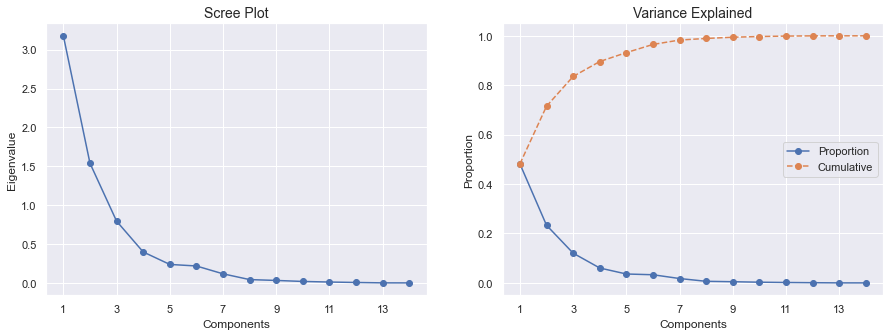

In [28]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

- the first two Coponents explain 70% of the variance
- the first four Components explain 90% of the variance

In [29]:
# testing PCA with the 4 principal components
pca = PCA(n_components=4)
pca_feat = pca.fit_transform(df_pca)
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)
pca_df

,PC0,PC1,PC2,PC3
0,1.192423,-0.520938,-0.940179,-0.879101
1,2.603452,0.030786,0.691237,-0.250649
2,-2.494983,-0.643833,-0.679103,1.597182
3,-1.291758,-0.624540,0.567118,-0.070560
4,-0.738166,-1.314740,-0.392995,-0.039754
...,...,...,...,...
9936,1.391263,0.073132,-1.462974,0.735699
9937,-1.649012,-0.268472,-1.125814,1.573649
9938,-2.687084,5.389537,0.942305,0.017639
9939,1.343795,-0.368761,0.351696,0.193810


In [30]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,Dayswus,Age,Edu,Income,Freq,Recency,Monetary,LTV,Perdeal,WebPurchase,WebVisit,YearsAsCustomer,logIncome,logLTV,PC0,PC1,PC2,PC3
0,-0.688571,0.233333,1.000000,0.185938,0.4,-0.653846,0.434911,1.048913,-0.36,-0.300000,-0.25,-0.666667,0.169543,0.342311,1.192423,-0.520938,-0.940179,-0.879101
1,0.420000,0.900000,0.333333,0.787806,1.2,-0.365385,1.446746,1.304348,-0.46,-0.833333,-0.50,0.555556,0.616888,0.374778,2.603452,0.030786,0.691237,-0.250649
2,-0.651429,-1.000000,-1.666667,-0.955856,-0.4,0.076923,-0.341223,-0.179348,1.26,0.500000,0.50,-0.666667,-1.409957,-0.690800,-2.494983,-0.643833,-0.679103,1.597182
3,0.442857,-0.200000,-0.333333,-0.192293,-0.5,-0.115385,-0.343195,-0.176630,0.90,0.466667,0.25,0.555556,-0.197625,-0.690800,-1.291758,-0.624540,0.567118,-0.070560
4,-0.162857,-0.033333,-0.333333,-0.100907,-0.5,-0.942308,-0.344181,-0.149457,0.20,0.600000,0.00,-0.111111,-0.100521,-0.455939,-0.738166,-1.314740,-0.392995,-0.039754


In [31]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca.corr().loc[['Dayswus', 'Age', 'Edu', 'Income', 'Freq', 'Recency', 'Monetary', 'LTV',
       'Perdeal','WebPurchase', 'WebVisit', 'YearsAsCustomer', 'logIncome',
       'logLTV'], pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3
Dayswus,0.040703,-0.051588,0.977907,-0.033720
Age,0.918942,0.150792,-0.073884,-0.078966
Edu,0.171329,0.042829,-0.029441,-0.949173
Income,0.939443,0.147547,-0.063381,-0.086075
Freq,0.936891,0.119481,0.187878,0.067568
Recency,-0.320756,0.946655,0.028422,-0.001459
Monetary,0.922362,0.151091,0.194523,0.085758
LTV,0.885974,0.182926,0.126838,0.136710
Perdeal,-0.840397,-0.112704,0.051875,-0.017066
WebPurchase,-0.832537,-0.151391,0.108311,-0.116359


PCA0 is almost exlusively the combination of income/frequency/age/LTV, which all seem to have lots of overlap 
PCA1 is Recency, meaning we should probably include it in the clustering 
PCA2 is years as customer (40% webvisit) 
PCA3 is education
the rest are useless 

so given the PCA analysis and the correlation analysis we will try clustering with a combination of the following: 
- LTV/logLTV
- per deal
- recency 
- years as customer 
- education
- webvisit 

In [32]:
df.to_csv('cleaned_data.csv', index_label='Custid')

In [33]:
df_out.to_csv('outliers.csv', index_label='Custid')

#### Final data normalization: 

In [34]:
# Robust Scaler - Scale features using statistics that are robust to outliers.
robust = RobustScaler().fit(df)
df_norm = robust.transform(df)

# Convert the array to a pandas dataframe
df_norm = pd.DataFrame(df_norm, columns=df.columns).set_index(df.index)

# Modeling: 

In [35]:
# Final data quality check: 

In [36]:
##Variables included in clustering: 
clust=['LTV', 'Perdeal', 'Recency', 'YearsAsCustomer', 'Edu', 'WebVisit']

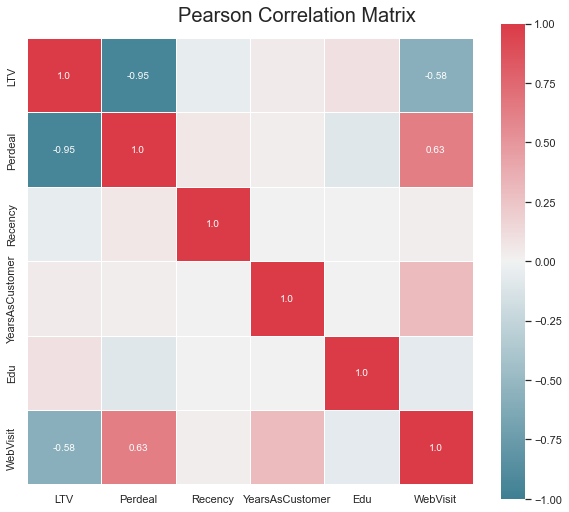

In [37]:
# Prepare figure
fig = plt.figure(figsize=(10, 8))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[clust].corr(method="spearman"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot)
mask_annot = np.absolute(corr.values) >= 0.5
annot = np.where(mask_annot, corr.values, np.full(corr.shape,""))

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Pearson Correlation Matrix", fontsize=20)

plt.show()

In [38]:
# Keep either LTV or Perdeal

In [39]:
value=['LTV', 'Recency', 'YearsAsCustomer', 'Edu', 'WebVisit']
pref=['Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']
df_val = df_norm[value].copy()
df_pr = df_norm[pref].copy()

### K-means:

### Defining the number of clusters:
#### Value Features: 

In [40]:
#range_clusters = range(1, 15)
#inertia = []
#for n_clus in range_clusters:  # iterate over desired ncluster range
#    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
#    kmclust.fit(df_val)
#    inertia.append(kmclust.inertia_)

In [41]:
## The inertia plot
#plt.figure(figsize=(9,5))
#plt.plot(inertia)
#ax.set_xlim(1, 24)
#plt.ylabel("Inertia: SSw")
#plt.xlabel("Number of clusters")
#plt.title("Inertia plot over clusters", size=15)
#plt.show()

We do not have a very distinct elbow point here. The optimum value of k can be around 2–6 from the above plot as inertia continues to drop steeply at least till k=4. And since we didn’t get a direct answer, we can also use the silhouette method. 

In [42]:
## Storing average silhouette metric
#avg_silhouette = []
#for nclus in range_clusters:
#    # Skip nclus == 1
#    if nclus == 1:
#        continue
#    
#    # Create a figure
#    fig = plt.figure(figsize=(13, 7))
#
#    # Initialize the KMeans object with n_clusters value and a random generator
#    # seed of 10 for reproducibility.
#    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
#    cluster_labels = kmclust.fit_predict(df_val)
#
#    # The silhouette_score gives the average value for all the samples.
#    # This gives a perspective into the density and separation of the formed clusters
#    silhouette_avg = silhouette_score(df_val, cluster_labels)
#    avg_silhouette.append(silhouette_avg)
#    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")
#
#    # Compute the silhouette scores for each sample
#    sample_silhouette_values = silhouette_samples(df_val, cluster_labels)
#
#    y_lower = 10
#    for i in range(nclus):
#        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
#        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#        ith_cluster_silhouette_values.sort()
#        
#        # Get y_upper to demarcate silhouette y range size
#        size_cluster_i = ith_cluster_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i
#        
#        # Filling the silhouette
#        color = cm.nipy_spectral(float(i) / nclus)
#        plt.fill_betweenx(np.arange(y_lower, y_upper),
#                          0, ith_cluster_silhouette_values,
#                          facecolor=color, edgecolor=color, alpha=0.7)
#
#        # Label the silhouette plots with their cluster numbers at the middle
#        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#
#        # Compute the new y_lower for next plot
#        y_lower = y_upper + 10  # 10 for the 0 samples
#
#    plt.title("The silhouette plot for the various clusters.")
#    plt.xlabel("The silhouette coefficient values")
#    plt.ylabel("Cluster label")
#
#    # The vertical line for average silhouette score of all the values
#    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#    
#    # The silhouette coefficient can range from -1, 1
#    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
#    plt.xlim([xmin, xmax])
#    
#    # The (nclus+1)*10 is for inserting blank space between silhouette
#    # plots of individual clusters, to demarcate them clearly.
#    plt.ylim([0, len(df_val) + (nclus + 1) * 10])
#
#    plt.yticks([])  # Clear the yaxis labels / ticks
#    plt.xticks(np.arange(xmin, xmax, 0.1))

In [43]:
## The average silhouette plot
## The inertia plot
#plt.figure(figsize=(9,5))
#plt.plot(avg_silhouette)
#plt.ylabel("Average silhouette")
#plt.xlabel("Number of clusters")
#plt.title("Average silhouette plot over clusters", size=15)
#plt.show()

#### Preference Features: 

In [44]:
#range_clusters = range(1, 15)
#inertia = []
#for n_clus in range_clusters:  # iterate over desired ncluster range
#    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
#    kmclust.fit(df_pr)
#    inertia.append(kmclust.inertia_)

In [45]:
## The inertia plot
#plt.figure(figsize=(9,5))
#plt.plot(inertia)
#ax.set_xlim(1, 24)
#plt.ylabel("Inertia: SSw")
#plt.xlabel("Number of clusters")
#plt.title("Inertia plot over clusters", size=15)
#plt.show()

In [46]:
## Storing average silhouette metric
#avg_silhouette = []
#for nclus in range_clusters:
#    # Skip nclus == 1
#    if nclus == 1:
#        continue
#    
#    # Create a figure
#    fig = plt.figure(figsize=(13, 7))
#
#    # Initialize the KMeans object with n_clusters value and a random generator
#    # seed of 10 for reproducibility.
#    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
#    cluster_labels = kmclust.fit_predict(df_pr)
#
#    # The silhouette_score gives the average value for all the samples.
#    # This gives a perspective into the density and separation of the formed clusters
#    silhouette_avg = silhouette_score(df_pr, cluster_labels)
#    avg_silhouette.append(silhouette_avg)
#    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")
#
#    # Compute the silhouette scores for each sample
#    sample_silhouette_values = silhouette_samples(df_pr, cluster_labels)
#
#    y_lower = 10
#    for i in range(nclus):
#        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
#        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#        ith_cluster_silhouette_values.sort()
#        
#        # Get y_upper to demarcate silhouette y range size
#        size_cluster_i = ith_cluster_silhouette_values.shape[0]
#        y_upper = y_lower + size_cluster_i
#        
#        # Filling the silhouette
#        color = cm.nipy_spectral(float(i) / nclus)
#        plt.fill_betweenx(np.arange(y_lower, y_upper),
#                          0, ith_cluster_silhouette_values,
#                          facecolor=color, edgecolor=color, alpha=0.7)
#
#        # Label the silhouette plots with their cluster numbers at the middle
#        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
#
#        # Compute the new y_lower for next plot
#        y_lower = y_upper + 10  # 10 for the 0 samples
#
#    plt.title("The silhouette plot for the various clusters.")
#    plt.xlabel("The silhouette coefficient values")
#    plt.ylabel("Cluster label")
#
#    # The vertical line for average silhouette score of all the values
#    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
#    
#    # The silhouette coefficient can range from -1, 1
#    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
#    plt.xlim([xmin, xmax])
#    
#    # The (nclus+1)*10 is for inserting blank space between silhouette
#    # plots of individual clusters, to demarcate them clearly.
#    plt.ylim([0, len(df_pr) + (nclus + 1) * 10])
#
#    plt.yticks([])  # Clear the yaxis labels / ticks
#    plt.xticks(np.arange(xmin, xmax, 0.1))

In [47]:
## The average silhouette plot
## The inertia plot
#plt.figure(figsize=(9,5))
#plt.plot(avg_silhouette)
#plt.ylabel("Average silhouette")
#plt.xlabel("Number of clusters")
#plt.title("Average silhouette plot over clusters", size=15)
#plt.show()

In [48]:
## Applying the right clustering (algorithm and number of clusters) for each perspective
#kmeans = KMeans(
#    n_clusters=2,
#    init='k-means++',
#    n_init=20,
#    random_state=42
#)
#value_labels = kmeans.fit_predict(df_val)
#
#
#preference_labels = kmeans.fit_predict(df_pr)
#
#
#df_norm['value_labels'] = value_labels
#df_norm['preference_labels'] = preference_labels

In [49]:
#clust=['LTV', 'Recency', 'YearsAsCustomer', 'Edu', 'WebVisit','Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']

In [50]:
## Centroids of the concatenated cluster labels
#df_centroids = df_norm.groupby(['value_labels', 'preference_labels'])\
#    [clust].mean()
#df_centroids

### Merge

In [51]:
## Using Hierarchical clustering to merge the concatenated cluster centroids
#linkage='ward'
#distance='euclidean'
#hclust = AgglomerativeClustering(
#    linkage=linkage, 
#    affinity=distance, 
#    distance_threshold=0, 
#    n_clusters=None
#)
#hclust_labels = hclust.fit_predict(df_centroids)

In [52]:
## create the counts of samples under each node (number of points being merged)
#counts = np.zeros(hclust.children_.shape[0])
#n_samples = len(hclust.labels_)
#
## hclust.children_ contains the observation ids that are being merged together
## At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
#for i, merge in enumerate(hclust.children_):
#    # track the number of observations in the current cluster being formed
#    current_count = 0
#    for child_idx in merge:
#        if child_idx < n_samples:
#            # If this is True, then we are merging an observation
#            current_count += 1  # leaf node
#        else:
#            # Otherwise, we are merging a previously formed cluster
#            current_count += counts[child_idx - n_samples]
#    counts[i] = current_count
#
## the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
## the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
## the counts indicate the number of points being merged (dendrogram's x-axis)
#linkage_matrix = np.column_stack(
#    [hclust.children_, hclust.distances_, counts]
#).astype(float)
#
## Plot the corresponding dendrogram
#sns.set()
#fig = plt.figure(figsize=(11,5))
## The Dendrogram parameters need to be tuned
#y_threshold = 3
#dendrogram(linkage_matrix, truncate_mode='level', labels=df_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
#plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
#plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
#plt.xlabel('Number of points in node (or index of point if no parenthesis)')
#plt.ylabel(f'Euclidean Distance', fontsize=13)
#plt.show()

In [53]:
## Re-running the Hierarchical clustering based on the correct number of clusters
#hclust = AgglomerativeClustering(
#    linkage='ward', 
#    affinity='euclidean', 
#    n_clusters=3
#)
#hclust_labels = hclust.fit_predict(df_centroids)
#df_centroids['hclust_labels'] = hclust_labels
#
#df_centroids  # centroid's cluster labels

In [54]:
## Mapper between concatenated clusters and hierarchical clusters
#cluster_mapper = df_centroids['hclust_labels'].to_dict()
#
#df_ = df_norm.copy()
#
## Mapping the hierarchical clusters on the centroids to the observations
#df_['merged_labels'] = df_.apply(
#    lambda row: cluster_mapper[
#        (row['value_labels'], row['preference_labels'])
#    ], axis=1
#)
#
## Merged cluster centroids
#df_.groupby('merged_labels').mean()[clust]

In [55]:
## Setting df to have the final product, behavior and merged clusters
#df_final = df_.copy()

In [56]:
## using R²
#def get_ss(df):
#    ss = np.sum(df.var() * (df.count() - 1))
#    return ss  # return sum of sum of squares of each df variable
#
#sst = get_ss(df_final[clust])  # get total sum of squares
#ssw_labels = df_final[clust + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
#ssb = sst - np.sum(ssw_labels) 
#r2 = ssb / sst
#r2

In [57]:
#def cluster_profiles(df, label_columns, figsize, compar_titles=None):
#    """
#    Pass df with labels columns of one or multiple clustering labels. 
#    Then specify this label columns to perform the cluster profile according to them.
#    """
#    if compar_titles == None:
#        compar_titles = [""]*len(label_columns)
#        
#    sns.set()
#    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
#    for ax, label, titl in zip(axes, label_columns, compar_titles):
#        # Filtering df
#        drop_cols = [i for i in label_columns if i!=label]
#        dfax = df.drop(drop_cols, axis=1)
#        
#        # Getting the cluster centroids and counts
#        centroids = dfax.groupby(by=label, as_index=False).mean()
#        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
#        counts.columns = [label, "counts"]
#        
#        # Setting Data
#        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
#        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])
#
#        #Setting Layout
#        handles, _ = ax[0].get_legend_handles_labels()
#        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
#        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
#        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
#        ax[0].axhline(color="black", linestyle="--")
#        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
#        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
#        ax[1].set_xticklabels(cluster_labels)
#        ax[1].set_xlabel("")
#        ax[1].set_ylabel("Absolute Frequency")
#        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
#    
#    plt.subplots_adjust(hspace=0.4, top=0.90)
#    plt.suptitle("Cluster Simple Profilling", fontsize=23)
#    plt.show()

In [58]:
## Profilling each cluster (product, behavior, merged)
#cluster_profiles(
#    df = df_final[clust + ['value_labels', 'preference_labels', 'merged_labels']], 
#    label_columns = ['value_labels', 'preference_labels', 'merged_labels'], 
#    figsize = (28, 13), 
#    compar_titles = ["Value Clustering", "Preference clustering","Merged clusters"]
#)


__RENAN__



In [59]:
df_val.drop(['Recency'], axis=1,inplace=True)

__Checking the possible number of clusters using Hierarchical Clustering__

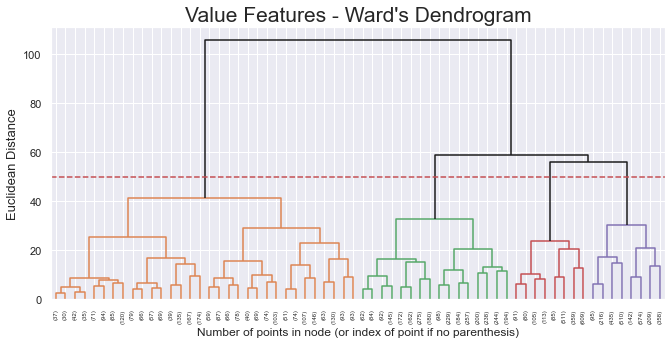

In [75]:
## Setting the ideal clusters quantity for Value

# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_val)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

# The Dendrogram parameters need to be tuned
y_threshold = 50
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Value Features - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

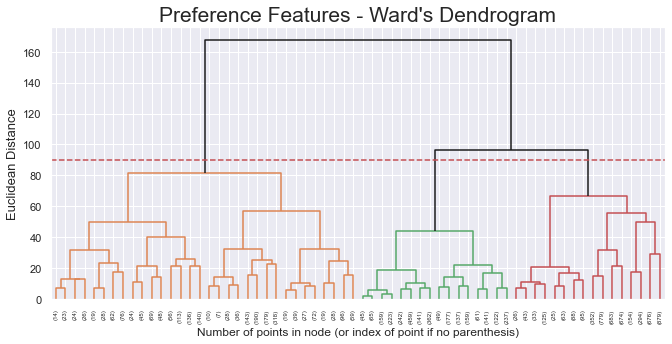

In [76]:
## Setting the ideal clusters quantity for Preferences

# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_pr)

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))

# The Dendrogram parameters need to be tuned
y_threshold = 90
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Preference Features - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

4 clusters seem good for Value, and for preferences it's hard to choose, I'm going with 3

Performing HC for Value

In [77]:
#### Performing HC for VAL
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=4)
hc_val_labels = hclust.fit_predict(df_val)

# Characterizing the clusters in the original df
df_hc_val = pd.concat((df[value], pd.Series(hc_val_labels, name='labels')), axis=1)
df_hc_val.groupby('labels').mean()

,LTV,Recency,YearsAsCustomer,Edu,WebVisit
labels,,,,,
0,609.927839,50.204330,2.480251,17.043297,2.769085
1,69.619535,63.269791,2.464947,18.653407,5.955494
2,50.729429,67.699718,2.050852,15.481441,5.446810
3,84.338454,62.544291,3.018792,15.738351,7.189452


Performing HC for Preferences

In [78]:
# Performing HC for Preferences
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=3)
hc_pr_labels = hclust.fit_predict(df_pr)

# Characterizing the clusters in the original df
df_hc_pr = pd.concat((df[pref], pd.Series(hc_pr_labels, name='labels')), axis=1)
df_hc_pr.groupby('labels').mean()

,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
labels,,,,,,
0,23.519098,17.206167,29.296364,15.893235,14.076852,29.319834
1,47.418597,5.413521,34.663965,6.000214,6.504299,12.738334
2,77.572148,1.712127,17.076286,1.782296,1.776898,12.791292


MERGE

In [79]:
df['value_labels'] = hc_val_labels
df['preference_labels'] = hc_pr_labels
clust=['LTV', 'YearsAsCustomer', 'Edu', 'WebVisit','Dryred','Sweetred','Drywh','Sweetwh','Dessert','Exotic']

In [80]:
# Centroids of the concatenated cluster labels
df_hc_centroids = df.groupby(['value_labels', 'preference_labels'])\
    [clust].mean()
df_hc_centroids

LTV  YearsAsCustomer        Edu  \
value_labels preference_labels                                           
0            0                  569.833708         2.438202  15.633708   
             1                  624.135837         2.472336  17.165654   
             2                  589.002653         2.567905  18.119363   
1            0                   38.282051         2.433974  17.948718   
             1                   63.720106         2.492914  18.575731   
             2                   78.829346         2.443620  18.811005   
2            0                   27.187375         2.097996  14.753507   
             1                   62.510110         2.039196  15.779513   
             2                   65.839744         1.997756  16.075321   
3            0                   46.660279         3.042683  14.982578   
             1                   93.301754         3.013567  15.897076   
             2                  110.986641         3.001145  16.307252   

                                WebVisit     Dryred   Sweetred      Drywh  \
value_labels preference_labels                                              
0            0                  2.132584  28.586517  16.164045  32.510112   
             1                  2.592490  44.806737   5.482606  36.950304   
             2                  4.368700  75.827586   2.010610  18.297082   
1            0                  5.673077  31.448718  15.544872  30.833333   
             1                  5.875111  53.499557   4.475642  32.345438   
             2                  6.062998  79.144338   1.362041  16.555024   
2            0                  5.565130  21.508016  17.760521  27.939880   
             1                  5.314252  46.352079   5.886980  33.518862   
             2                  5.511218  75.508013   2.136218  17.705128   
3            0                  7.266551  20.932056  17.501742  28.745645   
             1                  7.070175  46.410526   5.844444  34.481871   
             2                  7.299618  77.522901   1.830153  16.696565   

                                  Sweetwh    Dessert     Exotic  
value_labels preference_labels                                   
0            0                  13.170787   9.568539  12.413483  
             1                   6.088901   6.649365   6.645500  
             2                   1.888594   1.938992   7.554377  
1            0                  11.929487  10.217949  24.762821  
             1                   4.758193   4.941541  13.367582  
             2                   1.452153   1.381180  11.476077  
2            0                  17.006012  15.769539  34.389780  
             1                   6.783141   7.463105  17.135299  
             2                   2.256410   2.333333  16.048077  
3            0                  17.146341  15.677700  34.850174  
             1                   6.359064   6.921637  18.672515  
             2                   1.931298   1.944656  15.828244

In [81]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage='ward'
distance='euclidean'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    affinity=distance, 
    distance_threshold=0, 
    n_clusters=None
)
hclust_labels = hclust.fit_predict(df_hc_centroids)

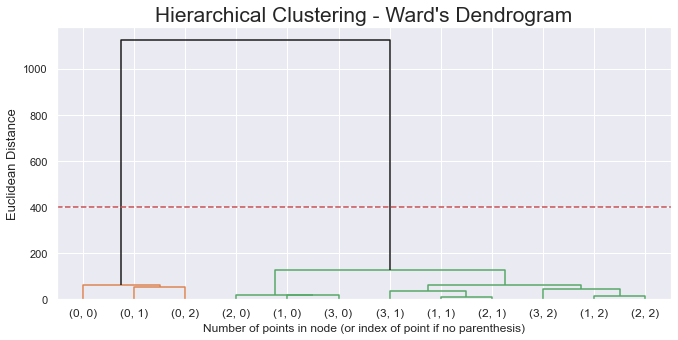

In [82]:
# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 400
dendrogram(linkage_matrix, truncate_mode='level', labels=df_hc_centroids.index, p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()

In [83]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    affinity='euclidean', 
    n_clusters=2
)
hclust_labels = hclust.fit_predict(df_hc_centroids)
df_hc_centroids['hclust_labels'] = hclust_labels

df_hc_centroids  # centroid's cluster labels

LTV  YearsAsCustomer        Edu  \
value_labels preference_labels                                           
0            0                  569.833708         2.438202  15.633708   
             1                  624.135837         2.472336  17.165654   
             2                  589.002653         2.567905  18.119363   
1            0                   38.282051         2.433974  17.948718   
             1                   63.720106         2.492914  18.575731   
             2                   78.829346         2.443620  18.811005   
2            0                   27.187375         2.097996  14.753507   
             1                   62.510110         2.039196  15.779513   
             2                   65.839744         1.997756  16.075321   
3            0                   46.660279         3.042683  14.982578   
             1                   93.301754         3.013567  15.897076   
             2                  110.986641         3.001145  16.307252   

                                WebVisit     Dryred   Sweetred      Drywh  \
value_labels preference_labels                                              
0            0                  2.132584  28.586517  16.164045  32.510112   
             1                  2.592490  44.806737   5.482606  36.950304   
             2                  4.368700  75.827586   2.010610  18.297082   
1            0                  5.673077  31.448718  15.544872  30.833333   
             1                  5.875111  53.499557   4.475642  32.345438   
             2                  6.062998  79.144338   1.362041  16.555024   
2            0                  5.565130  21.508016  17.760521  27.939880   
             1                  5.314252  46.352079   5.886980  33.518862   
             2                  5.511218  75.508013   2.136218  17.705128   
3            0                  7.266551  20.932056  17.501742  28.745645   
             1                  7.070175  46.410526   5.844444  34.481871   
             2                  7.299618  77.522901   1.830153  16.696565   

                                  Sweetwh    Dessert     Exotic  hclust_labels  
value_labels preference_labels                                                  
0            0                  13.170787   9.568539  12.413483              1  
             1                   6.088901   6.649365   6.645500              1  
             2                   1.888594   1.938992   7.554377              1  
1            0                  11.929487  10.217949  24.762821              0  
             1                   4.758193   4.941541  13.367582              0  
             2                   1.452153   1.381180  11.476077              0  
2            0                  17.006012  15.769539  34.389780              0  
             1                   6.783141   7.463105  17.135299              0  
             2                   2.256410   2.333333  16.048077              0  
3            0                  17.146341  15.677700  34.850174              0  
             1                   6.359064   6.921637  18.672515              0  
             2                   1.931298   1.944656  15.828244              0

In [84]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_hc_centroids['hclust_labels'].to_dict()

df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_labels'], row['preference_labels'])
    ], axis=1
)

# Merged cluster centroids
df_hc.groupby('merged_labels').mean()[clust]

,LTV,YearsAsCustomer,Edu,WebVisit,Dryred,Sweetred,Drywh,Sweetwh,Dessert,Exotic
merged_labels,,,,,,,,,,
0,66.274093,2.453394,16.652126,6.089247,52.107058,7.016291,26.788796,7.091416,6.971257,19.485981
1,609.927839,2.480251,17.043297,2.769085,46.507026,6.790733,33.529054,6.684390,6.468287,7.750475


In [85]:
# Setting df to have the final product, behavior and merged clusters
df_hc_final = df_hc.copy()

In [86]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_hc[clust])  # get total sum of squares
ssw_labels = df_hc[clust + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels) 
r2 = ssb / sst
r2

0.664616128078889

In [87]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

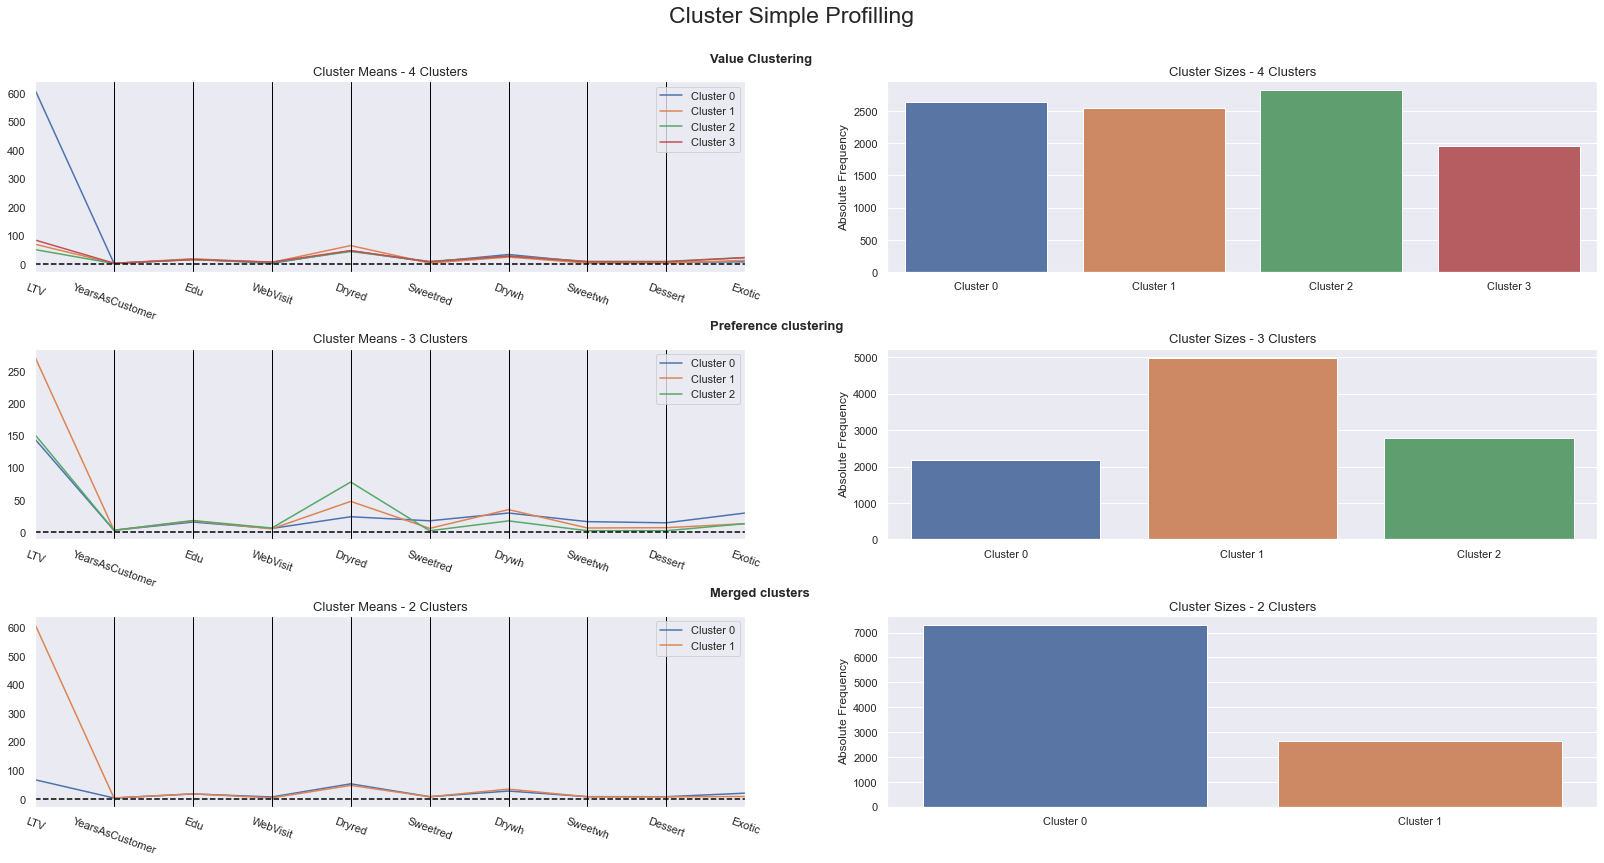

In [88]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_hc[clust + ['value_labels', 'preference_labels', 'merged_labels']], 
    label_columns = ['value_labels', 'preference_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compar_titles = ["Value Clustering", "Preference clustering","Merged clusters"]
)